## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
from IPython.display import clear_output
from random import sample
import string
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text =  ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here
token_to_id = {
    token: idx for idx, token in enumerate(tokens)
}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: word for word, idx in token_to_id.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [7]:
num_tokens = len(tokens)
num_tokens

38

In [8]:
encoded = np.array([token_to_id[ch] for ch in text])

In [9]:
encoded

array([ 1,  1, 17, ..., 16,  8,  0])

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
seq_size = 32
batch_size = 32
rnn_size = num_tokens
embedding_size = num_tokens

In [11]:
num_batches = int(len(encoded) / (seq_size * batch_size))
in_text = encoded[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]
in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))

In [12]:
in_text

array([[ 1,  1, 17, ..., 25, 26, 29],
       [ 1, 25, 26, ..., 20, 14, 19],
       [ 1, 31, 26, ..., 25, 31, 16],
       ...,
       [16,  1, 16, ..., 22, 20, 25],
       [15, 10,  0, ..., 19, 16, 12],
       [33, 16, 25, ..., 16, 36, 16]])

In [13]:
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

In [14]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, rnn_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.rnn_size = rnn_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_size,  batch_first=True)
        self.dense = nn.Linear(rnn_size, num_tokens)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = (self.rnn(embed, prev_state))
        logits = self.dense(output)
        return logits, state        
        
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_size),
                torch.zeros(1, batch_size, self.rnn_size))

In [17]:
rnn = RNNModule(num_tokens, seq_size, embedding_size, rnn_size)
iteration = 0

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [20]:
epoch_loss = []
best_loss = np.inf
for epoch in range(200):
    batches = get_batches(in_text, out_text, batch_size, seq_size)
    state_h, _ = rnn.zero_state(batch_size)

    for x, y in batches:
        rnn.train()
        optimizer.zero_grad()

        x = torch.tensor(x).to(torch.int64)
        y = torch.tensor(y).to(torch.int64)

        logits, state_h = rnn(x, state_h)
        loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()

        loss_value = loss.item()
        loss.backward()

        _ = torch.nn.utils.clip_grad_norm_(
            rnn.parameters(), 5)

        optimizer.step()
        if iteration % 100 == 0:
            print('Epoch: {}/{}'.format(epoch, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

        iteration += 1

    if loss_value < best_loss:
        torch.save(rnn.state_dict(), 'checkpoint_pt/model-rnn.pth')
            
    epoch_loss.append(loss_value)

Epoch: 0/200 Iteration: 0 Loss: 3.6473960876464844
Epoch: 1/200 Iteration: 100 Loss: 2.0516281127929688
Epoch: 2/200 Iteration: 200 Loss: 1.8408257961273193
Epoch: 3/200 Iteration: 300 Loss: 1.8268786668777466
Epoch: 4/200 Iteration: 400 Loss: 1.8289058208465576
Epoch: 5/200 Iteration: 500 Loss: 1.764262080192566
Epoch: 6/200 Iteration: 600 Loss: 1.7065975666046143
Epoch: 7/200 Iteration: 700 Loss: 1.7670657634735107
Epoch: 8/200 Iteration: 800 Loss: 1.7060751914978027
Epoch: 9/200 Iteration: 900 Loss: 1.6568818092346191
Epoch: 10/200 Iteration: 1000 Loss: 1.7554211616516113
Epoch: 11/200 Iteration: 1100 Loss: 1.756462574005127
Epoch: 12/200 Iteration: 1200 Loss: 1.717341423034668
Epoch: 13/200 Iteration: 1300 Loss: 1.6512439250946045
Epoch: 14/200 Iteration: 1400 Loss: 1.758185863494873
Epoch: 15/200 Iteration: 1500 Loss: 1.6951009035110474
Epoch: 16/200 Iteration: 1600 Loss: 1.7275354862213135
Epoch: 17/200 Iteration: 1700 Loss: 1.6353915929794312
Epoch: 18/200 Iteration: 1800 Loss: 

Epoch: 152/200 Iteration: 14800 Loss: 1.6370313167572021
Epoch: 153/200 Iteration: 14900 Loss: 1.6931369304656982
Epoch: 154/200 Iteration: 15000 Loss: 1.678329348564148
Epoch: 155/200 Iteration: 15100 Loss: 1.643912672996521
Epoch: 156/200 Iteration: 15200 Loss: 1.7142940759658813
Epoch: 157/200 Iteration: 15300 Loss: 1.7681509256362915
Epoch: 158/200 Iteration: 15400 Loss: 1.723219633102417
Epoch: 159/200 Iteration: 15500 Loss: 1.6144464015960693
Epoch: 160/200 Iteration: 15600 Loss: 1.672873854637146
Epoch: 161/200 Iteration: 15700 Loss: 1.7072937488555908
Epoch: 162/200 Iteration: 15800 Loss: 1.6897852420806885
Epoch: 163/200 Iteration: 15900 Loss: 1.6820640563964844
Epoch: 164/200 Iteration: 16000 Loss: 1.7403379678726196
Epoch: 165/200 Iteration: 16100 Loss: 1.7060902118682861
Epoch: 167/200 Iteration: 16200 Loss: 1.6704965829849243
Epoch: 168/200 Iteration: 16300 Loss: 1.690456748008728
Epoch: 169/200 Iteration: 16400 Loss: 1.6521977186203003
Epoch: 170/200 Iteration: 16500 Loss

In [140]:
epoch_loss = []
best_loss = np.inf
for epoch in range(200):
    batches = get_batches(in_text, out_text, batch_size, seq_size)
    state_h, _ = rnn.zero_state(batch_size)

    for x, y in batches:
        rnn.train()
        optimizer.zero_grad()

        x = torch.tensor(x).to(torch.int64)
        y = torch.tensor(y).to(torch.int64)

        logits, state_h = rnn(x, state_h)
        loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        loss_value = loss.item()
        loss.backward()

        _ = torch.nn.utils.clip_grad_norm_(
            rnn.parameters(), 5)

        optimizer.step()
        if iteration % 100 == 0:
            print('Epoch: {}/{}'.format(epoch, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

        iteration += 1

    if loss_value < best_loss:
        torch.save(rnn.state_dict(), 'checkpoint_pt/model-rnn.pth')
            
    epoch_loss.append(loss_value)

Epoch: 0/200 Iteration: 0 Loss: 3.7740490436553955
Epoch: 1/200 Iteration: 100 Loss: 2.0620903968811035
Epoch: 2/200 Iteration: 200 Loss: 1.8678735494613647
Epoch: 3/200 Iteration: 300 Loss: 1.8404120206832886
Epoch: 4/200 Iteration: 400 Loss: 1.8206110000610352
Epoch: 5/200 Iteration: 500 Loss: 1.7592219114303589
Epoch: 6/200 Iteration: 600 Loss: 1.6909359693527222
Epoch: 7/200 Iteration: 700 Loss: 1.7544842958450317
Epoch: 8/200 Iteration: 800 Loss: 1.7142771482467651
Epoch: 9/200 Iteration: 900 Loss: 1.6641768217086792
Epoch: 10/200 Iteration: 1000 Loss: 1.7646279335021973
Epoch: 11/200 Iteration: 1100 Loss: 1.724870204925537
Epoch: 12/200 Iteration: 1200 Loss: 1.7074272632598877
Epoch: 13/200 Iteration: 1300 Loss: 1.6833997964859009
Epoch: 14/200 Iteration: 1400 Loss: 1.7776672840118408
Epoch: 15/200 Iteration: 1500 Loss: 1.6979875564575195
Epoch: 16/200 Iteration: 1600 Loss: 1.7545955181121826
Epoch: 17/200 Iteration: 1700 Loss: 1.6662659645080566
Epoch: 18/200 Iteration: 1800 Los

Plot the loss function (axis X: number of epochs, axis Y: loss function).

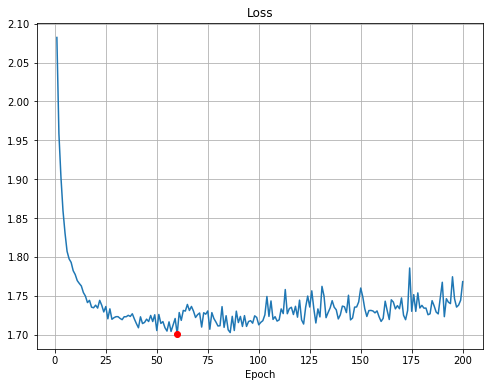

In [141]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(epoch_loss))+1, epoch_loss)
plt.plot(np.argmin(epoch_loss)+1, np.min(epoch_loss), 'ro')
plt.xlabel('Epoch')
plt.title("Loss")
plt.grid()

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

In [158]:
seq_size = 32
batch_size = 32
lstm_size = 38
embedding_size = 38

In [12]:
num_batches = int(len(encoded) / (seq_size * batch_size))
in_text = encoded[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]
in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))

In [161]:
class LSTModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(LSTModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size, lstm_size,  batch_first=True)
        self.dense = nn.Linear(lstm_size, num_tokens)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state        
        
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))

In [162]:
net = LSTModule(num_tokens, seq_size, embedding_size, lstm_size)
iteration = 0

In [163]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [21]:
epoch_loss = []
best_loss = np.inf
for epoch in range(200):
    batches = get_batches(in_text, out_text, batch_size, seq_size)
    state_h, state_c = net.zero_state(batch_size)

    for x, y in batches:
        net.train()
        optimizer.zero_grad()

        x = torch.tensor(x).to(torch.int64)
        y = torch.tensor(y).to(torch.int64)

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()
        loss_value = loss.item()
        loss.backward()

        _ = torch.nn.utils.clip_grad_norm_(
            net.parameters(), 5)

        optimizer.step()
        if iteration % 100 == 0:
            print('Epoch: {}/{}'.format(epoch, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

        iteration += 1
    if loss_value < best_loss:
        torch.save(net.state_dict(),
                   'checkpoint_pt/model-lstm.pth')            
    epoch_loss.append(loss_value)

Epoch: 0/200 Iteration: 0 Loss: 3.640289068222046
Epoch: 1/200 Iteration: 100 Loss: 2.05541729927063
Epoch: 2/200 Iteration: 200 Loss: 1.843192219734192
Epoch: 3/200 Iteration: 300 Loss: 1.7879966497421265
Epoch: 4/200 Iteration: 400 Loss: 1.780694842338562
Epoch: 5/200 Iteration: 500 Loss: 1.7164909839630127
Epoch: 6/200 Iteration: 600 Loss: 1.6264777183532715
Epoch: 7/200 Iteration: 700 Loss: 1.6994142532348633
Epoch: 8/200 Iteration: 800 Loss: 1.629487156867981
Epoch: 9/200 Iteration: 900 Loss: 1.53121817111969
Epoch: 10/200 Iteration: 1000 Loss: 1.6839323043823242
Epoch: 11/200 Iteration: 1100 Loss: 1.6572623252868652
Epoch: 12/200 Iteration: 1200 Loss: 1.6023732423782349
Epoch: 13/200 Iteration: 1300 Loss: 1.5797216892242432
Epoch: 14/200 Iteration: 1400 Loss: 1.6779074668884277
Epoch: 15/200 Iteration: 1500 Loss: 1.5917341709136963
Epoch: 16/200 Iteration: 1600 Loss: 1.644881010055542
Epoch: 17/200 Iteration: 1700 Loss: 1.538813591003418
Epoch: 18/200 Iteration: 1800 Loss: 1.5484

Plot the loss function (axis X: number of epochs, axis Y: loss function).

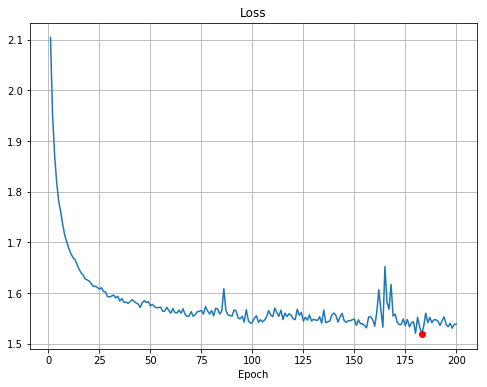

In [32]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(epoch_loss))+1, epoch_loss)
plt.plot(np.argmin(epoch_loss)+1, np.min(epoch_loss), 'ro')
plt.xlabel('Epoch')
plt.title("Loss")
plt.grid()

In [ ]:
1.427

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [181]:
# initial_words = 'hello '
# temperature = 1
# def predict(net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=1):
#     net.eval()
#     state_h, state_c = net.zero_state(1)
#     for w in words:
#         ix = torch.tensor([[token_to_id[w]]])
#         output, (state_h, state_c) = net(ix, (state_h, state_c))
    
#     _, top_ix = torch.topk(output[0], k=top_k)
#     choices = top_ix.tolist()
#     choice = np.random.choice(choices[0])

#     words += int_to_vocab[choice]
#     for _ in range(100):
#         ix = torch.tensor([[choice]]).to(torch.int64)
#         print(ix)
#         output, (state_h, state_c) = net(ix, (state_h, state_c))
        
#         p_next = F.softmax(output / temperature, dim=-1).data.numpy()[0]
# #         print(p_next.shape, len(tokens))
# #         next_ix = np.random.choice(len(tokens), p=p_next)
# #         next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
# #         print(x_sequence.shape, next_ix.shape)
# #         x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
#         _, ix = torch.topk(output[0], k=1)
#         choices = top_ix.tolist()
#         choice = np.random.choice(choices[0])
#         words += int_to_vocab[choice]

#     print(''.join(words))
# predict(net, initial_words, num_tokens, token_to_id, idx_to_token)

In [156]:
MAX_LENGTH = 16
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state, _ = char_rnn.zero_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
#         print(x_sequence[:, -1].shape, hid_state.shape)
        _, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
    
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [157]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
print(generate_sample(net, seed_phrase = 'wi', max_length=20, temperature=0.001))

torch.Size([1, 1, 2]) torch.Size([1, 1])


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 2 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:603

In [20]:
initial_words=['I', 'am'],
def predict(net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    state_h, state_c = net.zero_state(1)
    for w in words:
        ix = torch.tensor([[token_to_id[w]]])
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])
    for _ in range(100):
        ix = torch.tensor([[choice]])
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)